In [1]:
import numpy as np
from sklearn.cluster import KMeans
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string

In [2]:
# Compute inertia and assign labels to closest centroid
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances

def compute_inertia(centroids, data, threshold=100000, distance_metric='manhattan'):
    # Choose distance metric
    if distance_metric == 'euclidean':
        distances = euclidean_distances(data, centroids)
    elif distance_metric == 'manhattan':
        distances = manhattan_distances(data, centroids)
    else:
        raise ValueError("Unsupported distance metric. Choose 'euclidean' or 'manhattan'.")

    labels = np.argmin(distances, axis=1)
    min_distances = np.min(distances, axis=1)

    # Assign -1 for distances greater than threshold
    labels[min_distances > threshold] = -1

    # Compute inertia for assigned data points
    assigned_data_points = data[labels != -1]
    if len(assigned_data_points) > 0:
        assigned_labels = labels[labels != -1]
        inertia = np.sum((assigned_data_points - centroids[assigned_labels]) ** 2)
    else:
        inertia = 0

    # Calculate additional metrics if needed
    num_outliers = np.sum(labels == -1)
    average_distance = np.mean(min_distances[labels != -1]) if len(assigned_data_points) > 0 else 0

    return inertia

In [3]:
class GreyWolf:
    def __init__(self, data, n_clusters):
        self.position = data[np.random.choice(data.shape[0], n_clusters, replace=False), :]
        self.score = float('inf')

In [23]:
def gwo_kmeans(data, n_clusters, n_wolves=10, max_iter=100,kmeans_interval=20):
    wolves = [GreyWolf(data, n_clusters) for _ in range(n_wolves)]

    alpha, beta, delta = None, None, None

    for _ in range(max_iter):
        # Calculate fitness for each wolf
        for wolf in wolves:
            wolf.score = compute_inertia(wolf.position, data)
            if alpha is None or wolf.score < alpha.score:
                alpha, beta, delta = wolf, alpha, beta
            elif beta is None or wolf.score < beta.score:
                beta, delta = wolf, beta
            elif delta is None or wolf.score < delta.score:
                delta = wolf

        # Update positions
        a = 2 - 2 * _ / max_iter  # Decrease linearly from 2 to 0
        for wolf in wolves:
            for i in range(n_clusters):
                wolf.position[i] = (alpha.position[i] - a * abs(alpha.position[i] - wolf.position[i]) +
                                    beta.position[i] - a * abs(beta.position[i] - wolf.position[i]) +
                                    delta.position[i] - a * abs(delta.position[i] - wolf.position[i])) / 3
                        # KMeans refinement at specified intervals
        if i % kmeans_interval == 0 and i != 0:
            # Using current global best as initial centroids for KMeans refinement
            kmeans = KMeans(n_clusters=n_clusters, init=global_best_position, n_init=1)
            kmeans.fit(data)
            refined_centroids = kmeans.cluster_centers_

            # Update global best if KMeans refinement improves inertia
            refined_inertia, _ = compute_inertia_and_labels(refined_centroids, data)
            if refined_inertia < global_best_score:
                global_best_score = refined_inertia
                global_best_position = refined_centroids

    final_kmeans = KMeans(n_clusters=n_clusters, init=np.array(alpha.position), n_init=1, max_iter=300)
    final_kmeans.fit(data)
    return final_kmeans

In [5]:
newsgroups_dataset = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), random_state=42)

In [6]:
nltk.download('stopwords')
nltk.download('punkt')

# Initialize stopwords, stemmer, and punctuation set
stop_words = set(stopwords.words('english'))
punctuation_set = set(string.punctuation)
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to C:\Users\Devendra
[nltk_data]     Nemade\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Devendra
[nltk_data]     Nemade\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
def preprocess_text(text):
    # Tokenize text
    tokens = word_tokenize(text)
    # Convert to lowercase, remove punctuation, remove stopwords, and stem
    processed_tokens = [stemmer.stem(word.lower()) for word in tokens if word.lower() not in stop_words and word not in punctuation_set]
    # Re-join processed tokens into a single string
    return ' '.join(processed_tokens)

In [8]:
processed_data = [preprocess_text(doc) for doc in newsgroups_dataset.data]
# Use TfidfVectorizer to convert the raw text into TF-IDF features
print("Vectorizing the text data...")
tfidf_vectorizer = CountVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_data)
n_components = 100
svd = TruncatedSVD(n_components=n_components, random_state=42)
tfidf_matrix_reduced = svd.fit_transform(tfidf_matrix)


Vectorizing the text data...


In [9]:
if tfidf_matrix_reduced.dtype == 'float64':
    tfidf_matrix_reduced = tfidf_matrix_reduced.astype('float32')

In [24]:
n_clusters = 2
kmeans = gwo_kmeans(tfidf_matrix_reduced, n_clusters)
print("Cluster centers:", kmeans.cluster_centers_)
print("Labels:", kmeans.labels_)
#GWO-Kmeans on 20newsgroups


Cluster centers: [[ 5.04345655e-01  1.75398970e+00  6.15715533e-02 -1.08468807e+00
  -6.46427572e-02 -1.71508551e-01 -8.88242200e-02 -5.98451234e-02
   1.17831096e-01 -6.94411770e-02  7.37332646e-03  5.09967618e-02
   2.19510183e-01  6.04835749e-02 -1.34319991e-01 -1.91205647e-02
  -2.38375459e-02  4.01080400e-02 -1.25613704e-01 -4.55175005e-02
   2.97932830e-02  1.75041437e-01  9.19370130e-02  5.39145730e-02
   1.80910714e-02  1.26077861e-01  9.40385535e-02 -2.53615171e-01
  -3.52175608e-02 -4.90022004e-02  4.79284637e-02 -6.70244768e-02
  -2.52408814e-02 -1.14938527e-01 -7.61452783e-03 -3.08511630e-02
  -4.63499874e-03 -4.86795865e-02  5.34312949e-02 -6.47497326e-02
  -2.92198453e-02  2.16123909e-02 -5.38210869e-02  5.89767136e-02
   1.35851651e-02  6.32522255e-02  4.51857038e-02  1.35290608e-01
  -1.27435625e-02 -6.54510548e-03 -1.16699763e-01 -8.32765698e-02
   9.19513255e-02  1.58796534e-02  6.85447305e-02 -5.15954420e-02
  -8.22786689e-02  9.20831114e-02  5.36299013e-02 -8.896044

In [25]:
silhouette = silhouette_score(tfidf_matrix_reduced, kmeans.labels_)
davies_bouldin = davies_bouldin_score(tfidf_matrix_reduced, kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(tfidf_matrix_reduced, kmeans.labels_)

print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Index: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

Silhouette Score: 0.9985460638999939
Davies-Bouldin Index: 0.2824948114767199
Calinski-Harabasz Index: 98424.37855013048


In [29]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
Labels_save=[];
for n_clusters in range(2, 21):
    # Run PSO-KMeans with the current number of clusters
    kmeans =  gwo_kmeans(tfidf_matrix_reduced, n_clusters)
    
    # Calculate metrics
    silhouette = silhouette_score(tfidf_matrix_reduced, kmeans.labels_)
    print(silhouette)
    davies_bouldin = davies_bouldin_score(tfidf_matrix_reduced, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(tfidf_matrix_reduced, kmeans.labels_)
    
    # Store metrics
    silhouette_scores.append(silhouette)
    davies_bouldin_scores.append(davies_bouldin)
    calinski_harabasz_scores.append(calinski_harabasz)
#     pca = PCA(n_components=2)
#     pca_data = pca.fit_transform(tfidf_matrix_reduced)

# # Visualizing the clusters
#     plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans.labels_)
#     plt.title(f'PCA of KMeans Clusters ({n_clusters} Clusters)')
#     plt.show()

0.99854606
0.9977619
0.99767566
0.9792245
0.9847472
0.97971135
0.9969697
0.9487646
0.97413224
0.9845501
0.97530496
0.96543103
0.9790399
0.9678241
0.9494038
0.9306621
0.96772254
0.95041937
0.9487897


C:\Users\Devendra Nemade\AppData\Local\Temp\ipykernel_11932\1269032366.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Devendra Nemade\AppData\Local\Temp\ipykernel_11932\1269032366.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


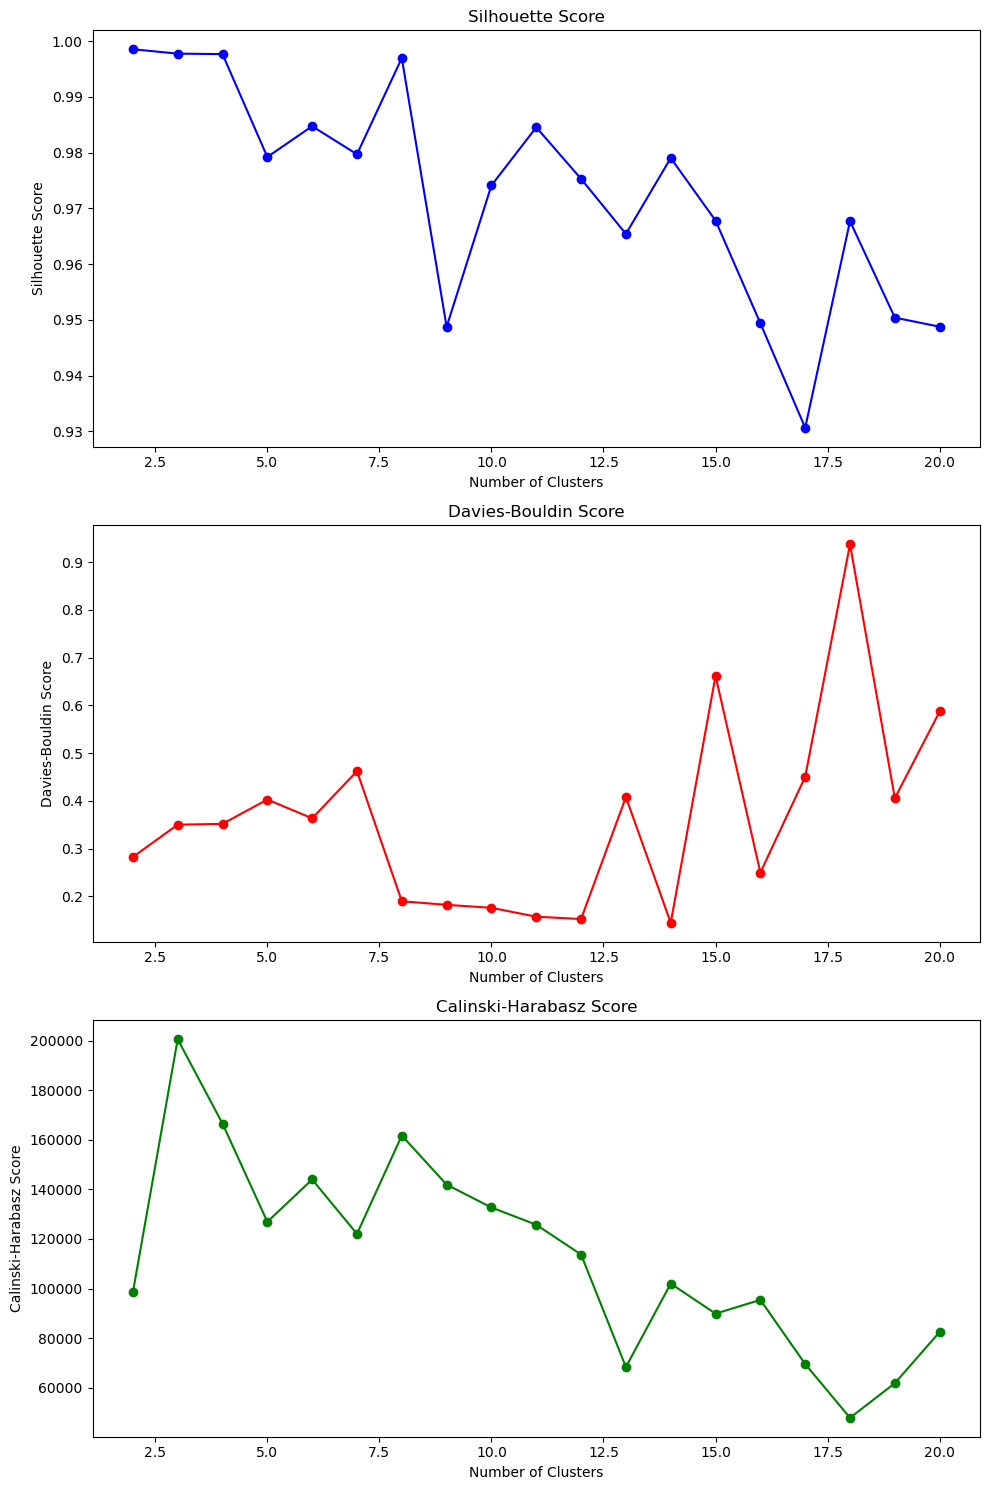

In [30]:
import matplotlib.pyplot as plt
# Plotting the metrics
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Silhouette Score
axs[0].plot(range(2, 21), silhouette_scores, marker='o', linestyle='-', color='blue')
axs[0].set_title('Silhouette Score')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Silhouette Score')
plt.savefig("Silhouette Score_News_countGWo-Kmeans.png")

# Davies-Bouldin Score
axs[1].plot(range(2, 21), davies_bouldin_scores, marker='o', linestyle='-', color='red')
axs[1].set_title('Davies-Bouldin Score')
axs[1].set_xlabel('Number of Clusters')
axs[1].set_ylabel('Davies-Bouldin Score')
plt.tight_layout()
plt.savefig("Davies-Bouldin Score_News_countGWo-Kmeans.png")
# Calinski-Harabasz Score
axs[2].plot(range(2, 21), calinski_harabasz_scores, marker='o', linestyle='-', color='green')
axs[2].set_title('Calinski-Harabasz Score')
axs[2].set_xlabel('Number of Clusters')
axs[2].set_ylabel('Calinski-Harabasz Score')
plt.tight_layout()
plt.savefig("Calinski-Harabasz Score_News_countGWo-Kmeans.png")
plt.tight_layout()
plt.show()

In [31]:
import pandas as pd
data = {'silhouette_scores':silhouette_scores,'davies_bouldin_scores': davies_bouldin_scores,
        'calinski_harabasz_scores': calinski_harabasz_scores}
df=pd.DataFrame(data,index=range(2, 21))
df

,silhouette_scores,davies_bouldin_scores,calinski_harabasz_scores
2,0.998546,0.282495,98424.378550
3,0.997762,0.350075,200523.053915
4,0.997676,0.351828,166492.885419
5,0.979225,0.402698,126890.950679
6,0.984747,0.363450,143963.117851
7,0.979711,0.462121,122034.431878
8,0.996970,0.189730,161683.033766
9,0.948765,0.182237,141894.822636
10,0.974132,0.176060,132678.558951
11,0.984550,0.157414,125717.156168


In [32]:
df.to_csv('News_count_GWOR-Kmeans.csv')